In [2]:
import joblib
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.linear_model import LinearRegression
import xgboost as xgb



"""Trains a linear regression model on the full dataset and stores output."""
# Load the data
data = pd.read_csv("data/properties.csv")
# IQR Outlier deletion

for column in [
    # "Price",
    "primary_energy_consumption_sqm",
    "nbr_bedrooms",
    "total_area_sqm",
    "nbr_frontages",
]:
    previous_count = data.shape[0]

    # IQR
    # Calculate the upper and lower limits
    Q1 = data[column].quantile(0.1)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    upper = Q3 + 1.5 * IQR

    # Create arrays of Boolean values indicating the outlier rows
    upper_array = np.where(data[column] >= upper)[0]

    # Removing the outliers
    numerical_data_IQR = data.drop(index=data.index[upper_array])

    print(
        f"\nRows removed from {column}:",
        previous_count - numerical_data_IQR.shape[0],
    )
    print("upper outliers:", len(upper_array))

    categorical_features = [
        "property_type",
        "subproperty_type",
        "locality",
        "equipped_kitchen",
        "state_building",
        "heating_type",
        "epc",
    ]
    numerical_features = [
        "construction_year",
        "total_area_sqm",
        "surface_land_sqm",
        "nbr_frontages",
        "fl_furnished",
        "nbr_bedrooms",
        "fl_open_fire",
        "fl_terrace",
        "terrace_sqm",
        "primary_energy_consumption_sqm",
        "fl_floodzone",
        "fl_double_glazing",
        "cadastral_income",
    ]
    # Define features to use
    X = data
    y = data["price"]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.20, random_state=505
    )

# Impute missing values using SimpleImputer
imputer = SimpleImputer(
    strategy="mean"
)  

# Fit the imputer to the data
imputer.fit(X_train[numerical_features])

# Transform the data by replacing NaN values with the imputed values
X_train[numerical_features] = imputer.transform(X_train[numerical_features])
X_test[numerical_features] = imputer.transform(X_test[numerical_features])

enc = OneHotEncoder()
enc.fit(
    X_train[categorical_features]
)  # Note the double brackets to create a DataFrame with a single column
X_train_features = enc.transform(X_train[categorical_features]).toarray()
X_train_features_df = pd.DataFrame(
    X_train_features, columns=enc.get_feature_names_out()
)
X_test_features = enc.transform(X_test[categorical_features]).toarray()
X_test_features_df = pd.DataFrame(
    X_test_features, columns=enc.get_feature_names_out()
)

scaler = MinMaxScaler()
scaler.fit(X_train[numerical_features])
scaled_train = scaler.transform(X_train[numerical_features])
scaled_test = scaler.transform(X_test[numerical_features])
scaled_train_df = pd.DataFrame(scaled_train, columns=scaler.get_feature_names_out())
scaled_test_df = pd.DataFrame(scaled_test, columns=scaler.get_feature_names_out())

X_train = pd.concat(
    [
        scaled_train_df.reset_index(drop=True),
        X_train_features_df,
    ],
    axis=1,
)
X_test = pd.concat(
    [
        scaled_test_df.reset_index(drop=True),
        X_test_features_df,
    ],
    axis=1,
)

print(f"Features: \n {X_train.columns.tolist()}")
# Define the model
model3 = xgb.XGBRegressor(reg_lambda=5, reg_alpha=1, objective='reg:squarederror', 
                        n_estimators=500, min_child_weight=14, max_depth=6, subsample =0.8, 
                        learning_rate=0.03, gamma=0.1, colsample_bytree=0.8, booster='gbtree')


# Train the model
model3.fit(X_train, y_train)
# Predict
train_score = r2_score(y_train, model3.predict(X_train))
test_score = r2_score(y_test, model3.predict(X_test))
print(f"Boost: Train R² score: {train_score}")
print(f"Boost: Test R² score: {test_score}")
# Train the model for LinearRegression
model2 = LinearRegression()
model2.fit(X_train, y_train)

train_score_line = r2_score(y_train, model2.predict(X_train))
test_score_line = r2_score(y_test, model2.predict(X_test))
print(f"Line: Train R² score: {train_score_line}")
print(f"Line: Test R² score: {test_score_line}")




Rows removed from primary_energy_consumption_sqm: 1053
upper outliers: 1053

Rows removed from nbr_bedrooms: 2866
upper outliers: 2866

Rows removed from total_area_sqm: 3161
upper outliers: 3161

Rows removed from nbr_frontages: 20
upper outliers: 20
Features: 
 ['construction_year', 'total_area_sqm', 'surface_land_sqm', 'nbr_frontages', 'fl_furnished', 'nbr_bedrooms', 'fl_open_fire', 'fl_terrace', 'terrace_sqm', 'primary_energy_consumption_sqm', 'fl_floodzone', 'fl_double_glazing', 'cadastral_income', 'property_type_APARTMENT', 'property_type_HOUSE', 'subproperty_type_APARTMENT', 'subproperty_type_APARTMENT_BLOCK', 'subproperty_type_BUNGALOW', 'subproperty_type_CASTLE', 'subproperty_type_CHALET', 'subproperty_type_COUNTRY_COTTAGE', 'subproperty_type_DUPLEX', 'subproperty_type_EXCEPTIONAL_PROPERTY', 'subproperty_type_FARMHOUSE', 'subproperty_type_FLAT_STUDIO', 'subproperty_type_GROUND_FLOOR', 'subproperty_type_HOUSE', 'subproperty_type_KOT', 'subproperty_type_LOFT', 'subproperty_type

In [9]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

# Load the data
data = pd.read_csv("data/properties.csv")
# IQR Outlier deletion


categorical_features = [
    "property_type",
    "subproperty_type",
    "locality",
    "equipped_kitchen",
    "state_building",
    "heating_type",
    "epc",
]
numerical_features = [
    "construction_year",
    "total_area_sqm",
    "surface_land_sqm",
    "nbr_frontages",
    "fl_furnished",
    "nbr_bedrooms",
    "fl_open_fire",
    "fl_terrace",
    "terrace_sqm",
    "primary_energy_consumption_sqm",
    "fl_floodzone",
        "fl_double_glazing",
        "cadastral_income",
    ]
    # Define features to use
X = data
y = data["price"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=505)

# Impute missing values using SimpleImputer

enc = OneHotEncoder()
enc.fit(
    X_train[categorical_features]
)  # Note the double brackets to create a DataFrame with a single column
X_train_features = enc.transform(X_train[categorical_features]).toarray()
X_train_features_df = pd.DataFrame(
    X_train_features, columns=enc.get_feature_names_out()
)
X_test_features = enc.transform(X_test[categorical_features]).toarray()
X_test_features_df = pd.DataFrame(
    X_test_features, columns=enc.get_feature_names_out()
)

X_train = pd.concat(
    [
        X_train[numerical_features].reset_index(drop=True),
        X_train_features_df,
    ],
    axis=1,
)
X_test = pd.concat(
    [
        X_test[numerical_features].reset_index(drop=True),
        X_test_features_df,
    ],
    axis=1,
)

model4 = RandomForestRegressor(
    n_estimators=1400,
    min_samples_split=5,
    min_samples_leaf=1,
    max_features='sqrt',
    max_depth=30,
    bootstrap=True
)
model4.fit(X_train, y_train)
preds = model4.predict(X_train)
preds_test= model4.predict(X_test)
mae_train = mean_absolute_error(y_train, preds)
mae_test = mean_absolute_error(y_test, preds_test)
print(f"mae for train: {mae_train}")
print(f"mae for test: {mae_test}")
train_score_line = r2_score(y_train, preds)
test_score_line = r2_score(y_test, preds_test)
print(f"Line: Train R² score: {train_score_line}")
print(f"Line: Test R² score: {test_score_line}")

mae for train: 60614.538103274426
mae for test: 94643.19913834578
Line: Train R² score: 0.8649242981043737
Line: Test R² score: 0.6747667937269607


In [22]:
print(data)

             id     price property_type    subproperty_type            region  \
0      34221000  225000.0     APARTMENT           APARTMENT          Flanders   
1       2104000  449000.0         HOUSE               HOUSE          Flanders   
2      34036000  335000.0     APARTMENT           APARTMENT  Brussels-Capital   
3      58496000  501000.0         HOUSE               HOUSE          Flanders   
4      48727000  982700.0     APARTMENT              DUPLEX          Wallonia   
...         ...       ...           ...                 ...               ...   
75506  30785000  210000.0     APARTMENT           APARTMENT          Wallonia   
75507  13524000  780000.0     APARTMENT           PENTHOUSE  Brussels-Capital   
75508  43812000  798000.0         HOUSE  MIXED_USE_BUILDING  Brussels-Capital   
75509  49707000  575000.0         HOUSE               VILLA          Flanders   
75510  65278000  515000.0     APARTMENT           PENTHOUSE          Flanders   

              province  loc

In [6]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 5, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=  37.8s
[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=  38.1s
[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=  38.2s
[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=600; total time=   0.1s
[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=600; total time=   0.1s
[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=600; total time=   0.2s
[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600; total time= 2.4min
[CV] END bootstrap=False, max_depth=90, 

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:547: FitFailedWarning: 
6 fits failed out of a total of 15.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py", line 1467, in wrapper
    estimator._validate_params()
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/sit

KeyboardInterrupt: 

In [7]:
rf_random.best_params_

{'n_estimators': 1400,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 30,
 'bootstrap': True}

In [33]:
import joblib
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.linear_model import LinearRegression
import xgboost as xgb



"""Trains a linear regression model on the full dataset and stores output."""
# Load the data
data = pd.read_csv("data/properties.csv")
# IQR Outlier deletion

for column in [
    # "Price",
    "primary_energy_consumption_sqm",
    "nbr_bedrooms",
    "total_area_sqm",
    "nbr_frontages",
]:
    previous_count = data.shape[0]

    # IQR
    # Calculate the upper and lower limits
    Q1 = data[column].quantile(0.1)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    upper = Q3 + 1.5 * IQR

    # Create arrays of Boolean values indicating the outlier rows
    upper_array = np.where(data[column] >= upper)[0]

    # Removing the outliers
    numerical_data_IQR = data.drop(index=data.index[upper_array])

    print(
        f"\nRows removed from {column}:",
        previous_count - numerical_data_IQR.shape[0],
    )
    print("upper outliers:", len(upper_array))

    categorical_features = [
        "property_type",
        "subproperty_type",
        "locality",
        "equipped_kitchen",
        "state_building",
        "heating_type",
        "epc",
    ]
    numerical_features = [
        'latitude',
        'longitude',
        "construction_year",
        "total_area_sqm",
        "surface_land_sqm",
        "nbr_frontages",
        "fl_furnished",
        "nbr_bedrooms",
        "fl_open_fire",
        "fl_terrace",
        "terrace_sqm",
        "primary_energy_consumption_sqm",
        "fl_floodzone",
        "fl_double_glazing",
        "cadastral_income",
    ]
    # Define features to use
    X = data
    y = data["price"]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.20, random_state=505
    )

enc = OneHotEncoder()
enc.fit(
    X_train[categorical_features]
)  # Note the double brackets to create a DataFrame with a single column
X_train_features = enc.transform(X_train[categorical_features]).toarray()
X_train_features_df = pd.DataFrame(
    X_train_features, columns=enc.get_feature_names_out()
)
X_test_features = enc.transform(X_test[categorical_features]).toarray()
X_test_features_df = pd.DataFrame(
    X_test_features, columns=enc.get_feature_names_out()
)

X_train = pd.concat(
    [
        X_train[numerical_features].reset_index(drop=True),
        X_train_features_df,
    ],
    axis=1,
)
X_test = pd.concat(
    [
        X_test[numerical_features].reset_index(drop=True),
        X_test_features_df,
    ],
    axis=1,
)
    
print(f"Features: \n {X_train.columns.tolist()}")

# Define the model
model3 = xgb.XGBRegressor(
    reg_lambda=3,  # Adjust regularization parameters
    reg_alpha=0.5,
    objective='reg:squarederror',
    n_estimators=1000,
    min_child_weight=25,  # Increase minimum child weight
    max_depth=5,  # Decrease maximum depth
    learning_rate=0.01,  # Decrease learning rate
    gamma=0.1,
    colsample_bytree=0.8,
    booster='gbtree'
)

# Train the model
model3.fit(X_train, y_train)
preds = model3.predict(X_train)
# Predict
train_score = r2_score(y_train, model3.predict(X_train))
test_score = r2_score(y_test, model3.predict(X_test))
print(f"Boost: Train R² score: {train_score}")
print(f"Boost: Test R² score: {test_score}")

# Impute missing values using SimpleImputer
imputer = SimpleImputer(
    strategy="mean"
)  # You can also use 'median', 'most_frequent', or 'constant'

# Fit the imputer to the data
imputer.fit(X_train[numerical_features])

# Transform the data by replacing NaN values with the imputed values
X_train[numerical_features] = imputer.transform(X_train[numerical_features])
X_test[numerical_features] = imputer.transform(X_test[numerical_features])


scaler = MinMaxScaler()
scaler.fit(X_train[numerical_features])
scaled_train = scaler.transform(X_train[numerical_features])
scaled_test = scaler.transform(X_test[numerical_features])
scaled_train_df = pd.DataFrame(scaled_train, columns=scaler.get_feature_names_out())
scaled_test_df = pd.DataFrame(scaled_test, columns=scaler.get_feature_names_out())

X_train = pd.concat(
    [
        scaled_train_df.reset_index(drop=True),
        pd.DataFrame(X_train_features_df),
    ],
    axis=1,
)
X_test = pd.concat(
    [
        scaled_test_df.reset_index(drop=True),
        pd.DataFrame(X_test_features_df),
    ],
    axis=1,
)

# Train the model for LinearRegression
model2 = LinearRegression()
model2.fit(X_train, y_train)

train_score_line = r2_score(y_train, model2.predict(X_train))
test_score_line = r2_score(y_test, model2.predict(X_test))
print(f"Line: Train R² score: {train_score_line}")
print(f"Line: Test R² score: {test_score_line}")



Rows removed from primary_energy_consumption_sqm: 1053
upper outliers: 1053

Rows removed from nbr_bedrooms: 2866
upper outliers: 2866

Rows removed from total_area_sqm: 3161
upper outliers: 3161

Rows removed from nbr_frontages: 20
upper outliers: 20
Features: 
 ['latitude', 'longitude', 'construction_year', 'total_area_sqm', 'surface_land_sqm', 'nbr_frontages', 'fl_furnished', 'nbr_bedrooms', 'fl_open_fire', 'fl_terrace', 'terrace_sqm', 'primary_energy_consumption_sqm', 'fl_floodzone', 'fl_double_glazing', 'cadastral_income', 'property_type_APARTMENT', 'property_type_HOUSE', 'subproperty_type_APARTMENT', 'subproperty_type_APARTMENT_BLOCK', 'subproperty_type_BUNGALOW', 'subproperty_type_CASTLE', 'subproperty_type_CHALET', 'subproperty_type_COUNTRY_COTTAGE', 'subproperty_type_DUPLEX', 'subproperty_type_EXCEPTIONAL_PROPERTY', 'subproperty_type_FARMHOUSE', 'subproperty_type_FLAT_STUDIO', 'subproperty_type_GROUND_FLOOR', 'subproperty_type_HOUSE', 'subproperty_type_KOT', 'subproperty_type

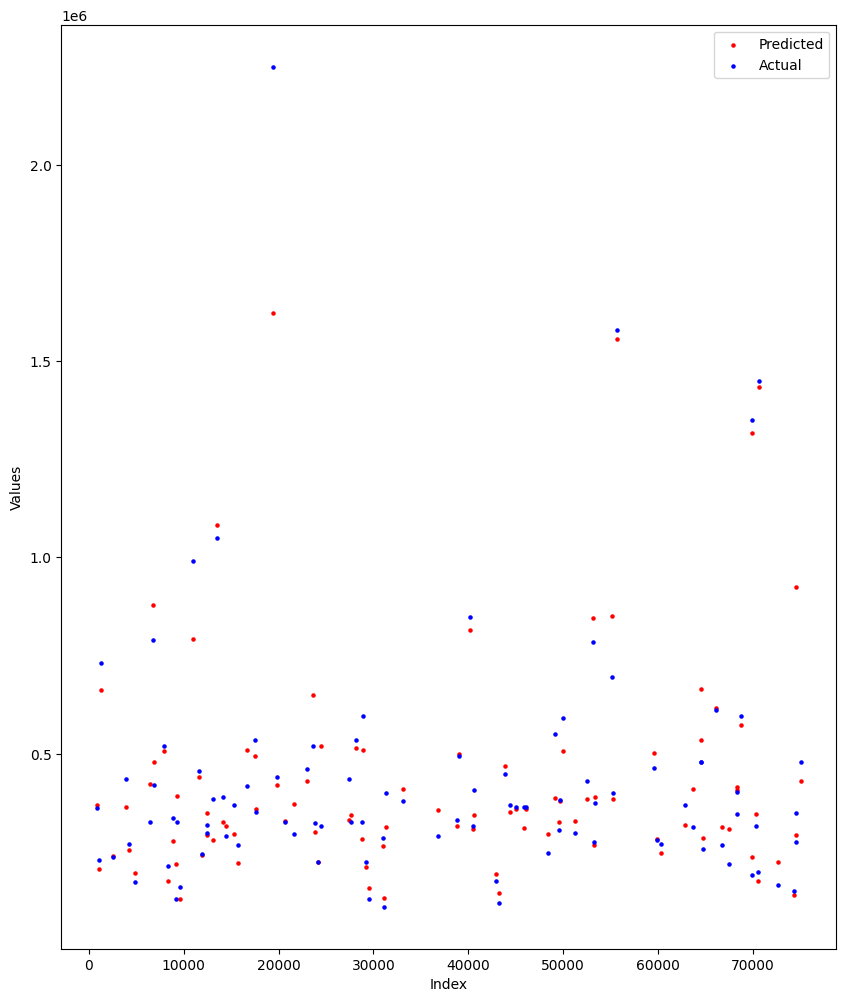

In [20]:
import matplotlib.pyplot as plt 
y_train = y_train[200:500]
preds = preds[200:500]
# Assuming preds is a pandas Series or DataFrame containing the predicted values
plt.figure(figsize=(10, 12))
plt.scatter(y_train.index, preds, c='red', label='Predicted', s=5)  # Set the size to 10
plt.scatter(y_train.index, y_train, c='blue', label='Actual', s=5)   # Set the size to 10
plt.xlabel('Index')
plt.ylabel('Values')
plt.legend()
plt.show()
